In [19]:
import matplotlib.pyplot as plt
import ee
import joblib
import geemap
from matplotlib.colors import ListedColormap
import geopandas as gpd
import matplotlib.patches as mpatches

In [7]:
# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize(project='svevazanettieo1') #così apro il progetto esistente in GEE, non ne sto creando uno nuovo

In [8]:
# Load model 
clf = joblib.load("random_forest_model_train+val.pkl")

In [67]:
sentinel2018 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2018')
sentinel2020 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2020')
sentinel2022 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2022')
sentinel2024 = ee.Image('projects/svevazanettieo1/assets/Dubai/sentinel2024')

AOI = ee.FeatureCollection('projects/svevazanettieo1/assets/Dubai/Area_of_interest_Dubai')

In [43]:
# Read with GeoPandas
gdf2018 = gpd.read_file("samples2018.geojson")
gdf2020 = gpd.read_file("samples2020.geojson")
gdf2022 = gpd.read_file("samples2022.geojson")
gdf2024 = gpd.read_file("samples2024.geojson")

In [77]:
print('Shape 2018', gdf2018.shape)
print('Shape 2020', gdf2020.shape)
print('Shape 2022', gdf2022.shape)
print('Shape 2024', gdf2024.shape)

Shape 2018 (870468, 11)
Shape 2020 (870468, 11)
Shape 2022 (870468, 11)
Shape 2024 (870468, 11)


In [35]:
def preprocess(gdf):
    gdf.columns = [col.replace('B', 'properties.B') for col in gdf.columns]
    gdf.columns = [col.replace('n', 'properties.n') for col in gdf.columns]
    feature_columns = [col for col in gdf.columns if col.startswith('properties.B') or col.startswith('properties.n')]
    whole_image = gdf[feature_columns]
    return whole_image

In [44]:
image2018 = preprocess(gdf2018)
image2020 = preprocess(gdf2020)
image2022 = preprocess(gdf2022)
image2024 = preprocess(gdf2024)

In [45]:
scaler = joblib.load("scaler.save")

image2018 = scaler.transform(image2018)
image2020 = scaler.transform(image2020)
image2022 = scaler.transform(image2022)
image2024 = scaler.transform(image2024)

In [46]:
y_pred_2018 = clf.predict(image2018)
gdf2018['predicted_class'] = y_pred_2018

y_pred_2020 = clf.predict(image2020)
gdf2020['predicted_class'] = y_pred_2020

y_pred_2022 = clf.predict(image2022)
gdf2022['predicted_class'] = y_pred_2022

y_pred_2024 = clf.predict(image2024)
gdf2024['predicted_class'] = y_pred_2024


In [39]:
gdf2024['predicted_class'].unique()

array([2, 3, 0, 1])

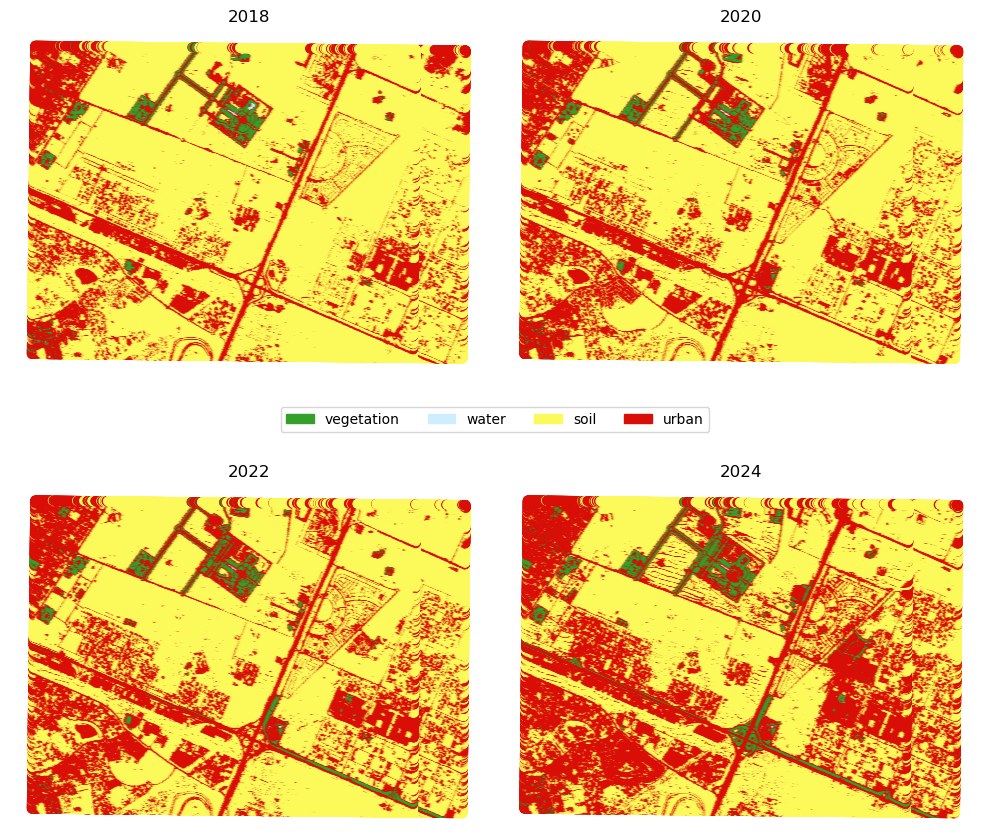

In [24]:
import matplotlib.patches as mpatches

# definisco i colori e le classi
colors = ["#34A02A", "#CEEEFF", "#FCF95BFF", "#D90E07FF"]  
classes = ['vegetation', 'water', 'soil', 'urban']
cmap = ListedColormap(colors)

# subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

title = ["2018", "2020", "2022", "2024"]
gdf = [gdf2018, gdf2020, gdf2022, gdf2024]

for i in range(len(title)):
    gdf_projected = gdf[i].to_crs(epsg=32640)
    gdf_projected.plot(ax=axes[i], column='predicted_class', cmap=cmap, legend=False)
    axes[i].set_title(title[i])
    axes[i].set_axis_off()

# aggiungo una legenda comune
patches = [mpatches.Patch(color=colors[j], label=classes[j]) for j in range(len(classes))]
fig.legend(handles=patches, loc='center', ncol=4)

plt.tight_layout()
plt.show()


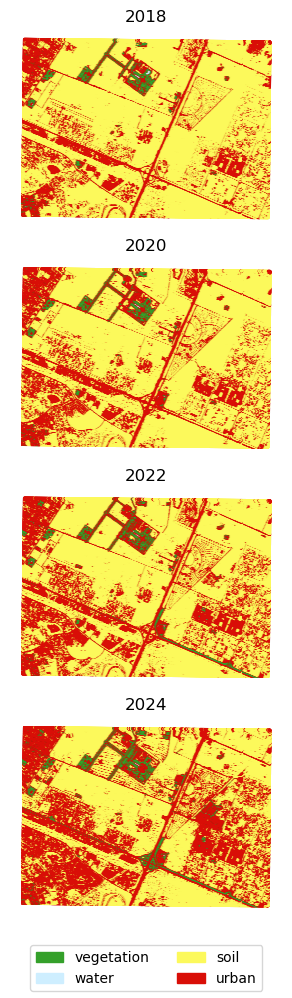

In [21]:


# definisco i colori e le classi
colors = ["#34A02A", "#CEEEFF", "#FCF95BFF", "#D90E07FF"]  
classes = ['vegetation', 'water', 'soil', 'urban']
cmap = ListedColormap(colors)

# subplot 4x1
fig, axes = plt.subplots(4, 1, figsize=(20, 10))
axes = axes.flatten()

title = ["2018", "2020", "2022", "2024"]
gdf = [gdf2018, gdf2020, gdf2022, gdf2024]

for i in range(len(title)):
    gdf_projected = gdf[i].to_crs(epsg=32640)
    gdf_projected.plot(ax=axes[i], column='predicted_class', cmap=cmap, legend=False, markersize=1)
    axes[i].set_title(title[i])
    axes[i].set_axis_off()

# aggiungo una legenda comune
patches = [mpatches.Patch(color=colors[j], label=classes[j]) for j in range(len(classes))]
fig.legend(handles=patches, loc='lower center', ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)

plt.show()

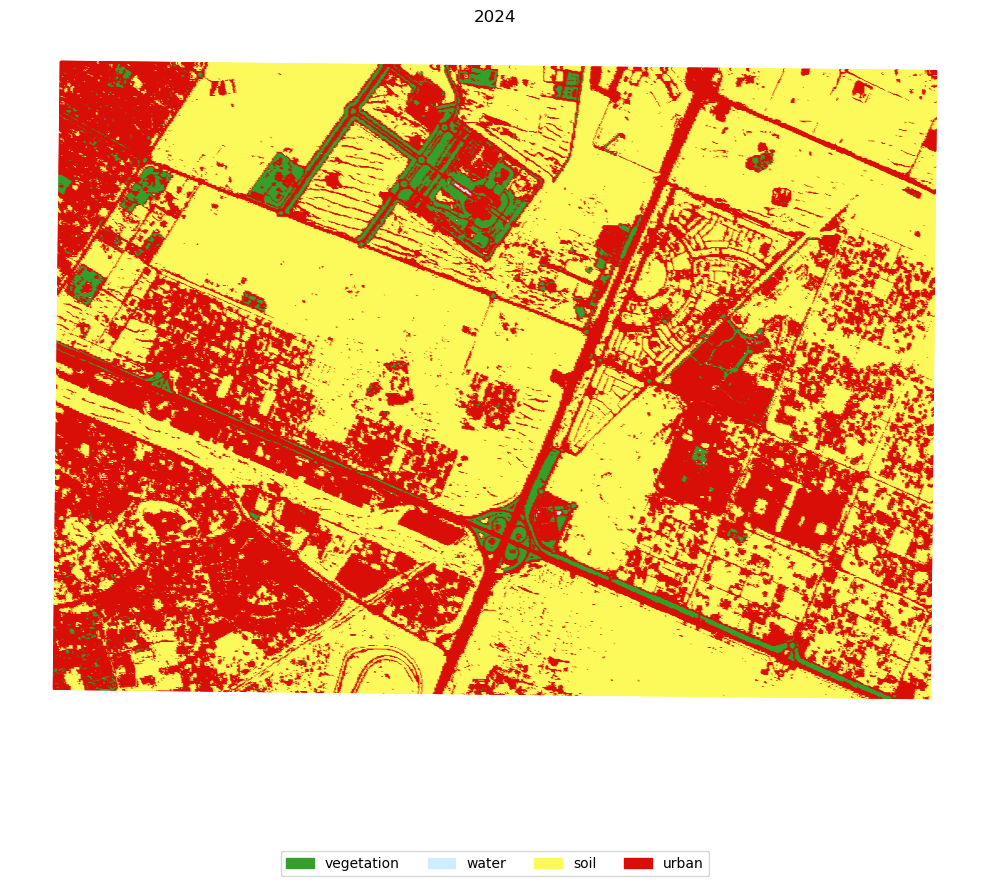

In [20]:
# definisco i colori e le classi
colors = ["#34A02A", "#CEEEFF", "#FCF95BFF", "#D90E07FF"]  
classes = ['vegetation', 'water', 'soil', 'urban']
cmap = ListedColormap(colors)

# subplot 1x1
fig, ax = plt.subplots(1,1, figsize=(10, 10))

title = "2024"
gdf =  gdf2024

gdf_projected = gdf.to_crs(epsg=32640)
gdf_projected.plot(ax=ax, column='predicted_class', cmap=cmap, legend=False,markersize=1)
ax.set_title(title)
ax.set_axis_off()

# aggiungo una legenda comune
patches = [mpatches.Patch(color=colors[j], label=classes[j]) for j in range(len(classes))]
fig.legend(handles=patches, loc='lower center', ncol=4)

plt.tight_layout()
plt.show()

In [83]:
# Create a map centered on AOI
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 0.3,
}
Map = geemap.Map(center=[25.25919846235865, 55.56474292797696], zoom=13)
Map.addLayer(sentinel2018, vis_params, 'Sentinel-2 2018')
Map.addLayer(sentinel2020, vis_params, 'Sentinel-2 2020')
Map.addLayer(sentinel2022, vis_params, 'Sentinel-2 2022')
Map.addLayer(sentinel2024, vis_params, 'Sentinel-2 2024')

Map

Map(center=[25.25919846235865, 55.56474292797696], controls=(WidgetControl(options=['position', 'transparent_b…

In [68]:
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 0.3,
}
maps = geemap.linked_maps(
    rows=1, cols=2,
    center=[25.25919846235865, 55.56474292797696],
    zoom=12.4,
    ee_objects=[sentinel2018, sentinel2024],
    vis_params=[vis_params]*2,
    labels=["2018", "2024"],
    label_position="topright",
)

maps


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [50]:
#count number of pixels:
soil2018=gdf2018[gdf2018['predicted_class'] == 2].shape[0]
water2018=gdf2018[gdf2018['predicted_class'] == 1].shape[0]
vegetation2018=gdf2018[gdf2018['predicted_class'] == 0].shape[0]
urban2018=gdf2018[gdf2018['predicted_class'] == 3].shape[0]

soil2020=gdf2020[gdf2020['predicted_class'] == 2].shape[0]
water2020=gdf2020[gdf2020['predicted_class'] == 1].shape[0]
vegetation2020=gdf2020[gdf2020['predicted_class'] == 0].shape[0]
urban2020=gdf2020[gdf2020['predicted_class'] == 3].shape[0]

soil2022=gdf2022[gdf2022['predicted_class'] == 2].shape[0]
water2022=gdf2022[gdf2022['predicted_class'] == 1].shape[0]
vegetation2022=gdf2022[gdf2022['predicted_class'] == 0].shape[0]
urban2022=gdf2022[gdf2022['predicted_class'] == 3].shape[0]

soil2024=gdf2024[gdf2024['predicted_class'] == 2].shape[0]
water2024=gdf2024[gdf2024['predicted_class'] == 1].shape[0]
vegetation2024=gdf2024[gdf2024['predicted_class'] == 0].shape[0]
urban2024=gdf2024[gdf2024['predicted_class'] == 3].shape[0]

In [57]:
print('      soil, water, vegetation, urban, total')
print('2018',soil2018, water2018, vegetation2018, urban2018, 'tot: ', soil2018+water2018+vegetation2018+urban2018)
#print(soil2020, water2020, vegetation2020, urban2020, 'tot: ', soil2020+water2020+vegetation2020+urban2020)
#print(soil2022, water2022, vegetation2022, urban2022, 'tot: ', soil2022+water2022+vegetation2022+urban2022)
print('2024',soil2024, water2024, vegetation2024, urban2024, 'tot: ', soil2024+water2024+vegetation2024+urban2024)

      soil, water, vegetation, urban, total
2018 663782 336 15707 190643 tot:  870468
2024 493858 180 29957 346473 tot:  870468


In [64]:
areasinglepixel=100*(10**-6)

areaveg2018=vegetation2018*areasinglepixel
areaveg2024=vegetation2024*areasinglepixel

areaurban2018=urban2018*areasinglepixel
areaurban2024=urban2024*areasinglepixel

areasoil2018=soil2018*areasinglepixel
areasoil2024=soil2024*areasinglepixel

areawater2018=water2018*areasinglepixel
areawater2024=water2024*areasinglepixel

print('       vegetation, water, soil, urban,')
print('2018', areaveg2018, areawater2018, areasoil2018, areaurban2018)
print('2024', areaveg2024, areawater2024, areasoil2024, areaurban2024)
print('difference in area', (areaveg2024-areaveg2018), (areawater2024-areawater2018), (areasoil2024-areasoil2018), (areaurban2024-areaurban2018))
print('percentage change', ((areaveg2024-areaveg2018)/areaveg2018)*100, ((areawater2024-areawater2018)/areawater2018)*100, ((areasoil2024-areasoil2018)/areasoil2018)*100, ((areaurban2024-areaurban2018)/areaurban2018)*100)


       vegetation, water, soil, urban,
2018 1.5706999999999998 0.0336 66.37819999999999 19.0643
2024 2.9957 0.018 49.385799999999996 34.647299999999994
difference in area 1.425 -0.0156 -16.992399999999996 15.582999999999995
percentage change 90.72388107213347 -46.42857142857143 -25.599368467358257 81.7391669245658


In [ ]:
# prova maschera
print(gdf2018['predicted_class'].unique())
print(gdf2024['predicted_class'].unique())
d2018=gdf2018.copy()
d2024=gdf2024.copy()

d2018["predicted_class"] = d2018["predicted_class"].where(d2018["predicted_class"] == 3, 10)
d2024["predicted_class"] = d2024["predicted_class"].where(d2024["predicted_class"] == 3, 15)
print(d2018['predicted_class'].unique())
print(d2024['predicted_class'].unique())

# differenza tra i due GeoDataFrame
diff = d2024.copy()
diff["predicted_class"] = d2024["predicted_class"] - d2018["predicted_class"]


[2 3 0 1]
[2 3 0 1]
[10  3]
[15  3]


In [48]:
diff['predicted_class'].unique()

array([ 5, -7,  0, 12])

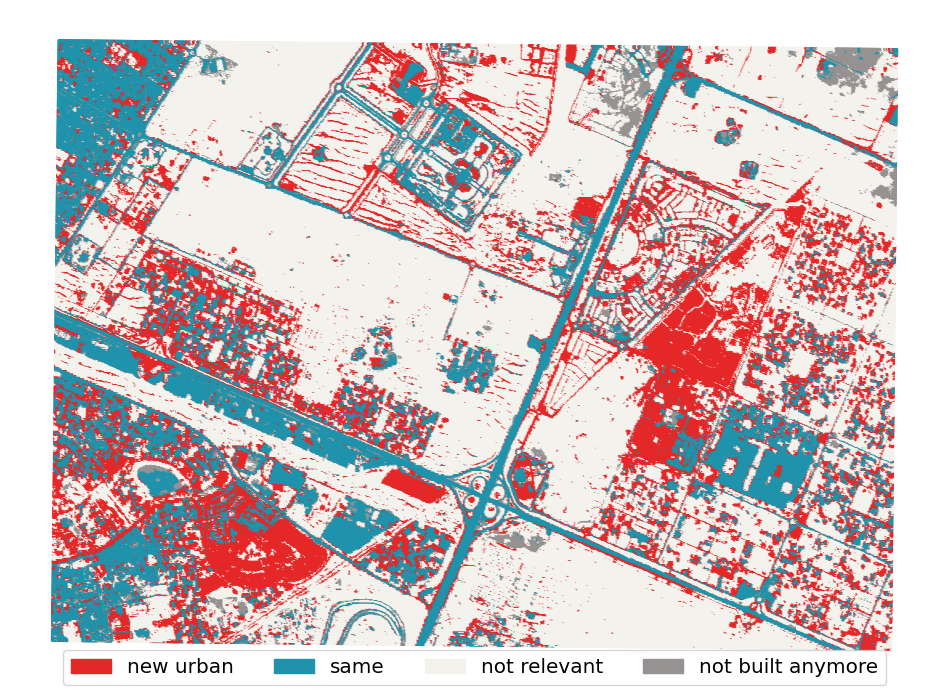

In [65]:
# definisco i colori e le classi
colors = ["#E62727", "#1E93AB", "#F3F2EC", "#969292"]  
classes = ['new urban','same', 'not relevant', 'not built anymore']
cmap = ListedColormap(colors)

# subplot 1x1
fig, ax = plt.subplots(1,1, figsize=(10, 7))

title = "Difference in built-up area 2018-2024"
gdf =  diff

gdf_projected = gdf.to_crs(epsg=32640)
gdf_projected.plot(ax=ax, column='predicted_class', cmap=cmap, legend=False, markersize=1)
ax.set_axis_off()

# aggiungo una legenda comune
patches = [mpatches.Patch(color=colors[j], label=classes[j]) for j in range(len(classes))]
fig.legend(handles=patches, loc='lower center', ncol=4, fontsize='x-large')

plt.tight_layout()
plt.show()